# Rapport d'optimisation des performances - API Credit Scoring

## Objectif

Ce notebook documente l'analyse de performance et l'optimisation du pipeline de prédiction de l'API de scoring crédit. 

**Architecture actuelle :**
- Modèle LightGBM (462 estimateurs, max_depth=3, 10 features, fichier pickle ~465 KB)
- Pipeline de prédiction : Pydantic → `pd.DataFrame` → réordonnancement colonnes → `predict_proba`
- Problème identifié : utilisation de pandas pour une prédiction ligne par ligne (overhead significatif)

**Approche :**
1. Profilage détaillé du pipeline actuel
2. Optimisation 1 : remplacement de pandas par numpy
3. Optimisation 2 : conversion ONNX Runtime
4. Validation de la précision et benchmarks comparatifs

In [1]:
import pickle
import time
import cProfile
import pstats
import io
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

PROJECT_ROOT = Path("..").resolve()
MODEL_PATH = PROJECT_ROOT / "results" / "lightgbm_optimized.pkl"
DATA_PATH = PROJECT_ROOT / "data" / "dataset_top10_features_data.csv"
LOG_PATH = PROJECT_ROOT / "logs" / "predictions.jsonl"
ONNX_OUTPUT_PATH = PROJECT_ROOT / "results" / "lightgbm_optimized.onnx"

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

FEATURE_ORDER = list(model.feature_name_)
print(f"Modèle chargé : {model.__class__.__name__}")
print(f"Nombre d'estimateurs : {model.n_estimators}")
print(f"Profondeur max : {model.max_depth}")
print(f"Features ({len(FEATURE_ORDER)}) : {FEATURE_ORDER}")
print(f"Taille du fichier pickle : {MODEL_PATH.stat().st_size / 1024:.1f} KB")

Modèle chargé : LGBMClassifier
Nombre d'estimateurs : 462
Profondeur max : 3
Features (10) : ['EXT_SOURCES_MEAN', 'CREDIT_TERM', 'EXT_SOURCE_3', 'GOODS_PRICE_CREDIT_PERCENT', 'INSTAL_AMT_PAYMENT_sum', 'AMT_ANNUITY', 'POS_CNT_INSTALMENT_FUTURE_mean', 'DAYS_BIRTH', 'EXT_SOURCES_WEIGHTED', 'EXT_SOURCE_2']
Taille du fichier pickle : 464.9 KB


## 2. Analyse des données de monitoring

Avant d'optimiser, analysons les données de latence collectées en production pour établir une baseline.

Nombre total de prédictions loguées : 1215
Prédictions réussies (200) : 1042

Distribution de la latence (duration_ms) :
count    1042.00
mean       46.39
std        50.83
min         0.00
25%        10.75
50%        31.74
75%        65.85
max       475.91
Name: duration_ms, dtype: float64


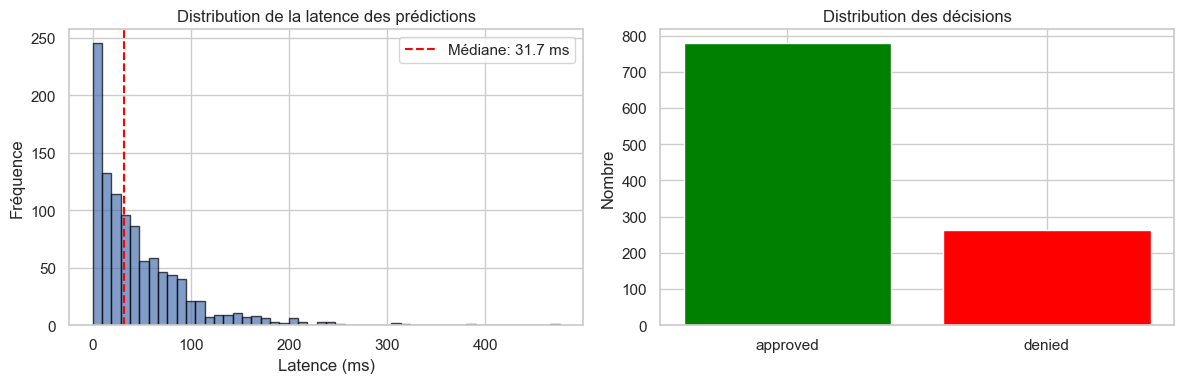

In [ ]:
logs = []
with open(LOG_PATH) as f:
    for line in f:
        logs.append(json.loads(line))

df_logs = pd.DataFrame(logs)
successful = df_logs[df_logs["status_code"] == 200]

print(f"Nombre total de prédictions loguées : {len(df_logs)}")f
print(f"Prédictions réussies (200) : {len(successful)}")
print(f"\nDistribution de la latence (duration_ms) :")
print(successful["duration_ms"].describe().round(2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(successful["duration_ms"], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Latence (ms)")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution de la latence des prédictions")
axes[0].axvline(successful["duration_ms"].median(), color="red", linestyle="--", label=f"Médiane: {successful['duration_ms'].median():.1f} ms")
axes[0].legend()

decision_counts = successful["credit_decision"].value_counts()
axes[1].bar(decision_counts.index, decision_counts.values, color=["green", "red"])
axes[1].set_ylabel("Nombre")
axes[1].set_title("Distribution des décisions")

plt.tight_layout()
plt.show()

## 3. Profilage avec cProfile et timeit

Micro-benchmark de chaque étape du pipeline de prédiction pour identifier les goulots d'étranglement.

In [3]:
from pydantic import BaseModel, Field

class CreditFeatures(BaseModel):
    EXT_SOURCES_MEAN: float = Field(ge=0.0, le=1.0)
    CREDIT_TERM: float = Field(ge=0.0, le=1.0)
    EXT_SOURCE_3: float = Field(ge=0.0, le=1.0)
    GOODS_PRICE_CREDIT_PERCENT: float = Field(ge=0.0, le=1.5)
    INSTAL_AMT_PAYMENT_sum: float = Field(ge=0.0, le=1e8)
    AMT_ANNUITY: float = Field(gt=0.0, le=1e6)
    POS_CNT_INSTALMENT_FUTURE_mean: float = Field(ge=0.0, le=200.0)
    DAYS_BIRTH: int = Field(lt=0, ge=-30000)
    EXT_SOURCES_WEIGHTED: float = Field(ge=0.0, le=3.0)
    EXT_SOURCE_2: float = Field(ge=0.0, le=1.0)

SAMPLE_INPUT = {
    "EXT_SOURCES_MEAN": 0.524,
    "CREDIT_TERM": 0.05,
    "EXT_SOURCE_3": 0.535,
    "GOODS_PRICE_CREDIT_PERCENT": 0.9,
    "INSTAL_AMT_PAYMENT_sum": 318619.5,
    "AMT_ANNUITY": 24903.0,
    "POS_CNT_INSTALMENT_FUTURE_mean": 6.95,
    "DAYS_BIRTH": -15750,
    "EXT_SOURCES_WEIGHTED": 1.5,
    "EXT_SOURCE_2": 0.566,
}

N_ITERATIONS = 10_000

def bench(fn, n=N_ITERATIONS):
    """Retourne le temps moyen en microsecondes."""
    start = time.perf_counter()
    for _ in range(n):
        fn()
    elapsed = time.perf_counter() - start
    return (elapsed / n) * 1e6  # µs

# Étape 1 : Validation Pydantic
t_pydantic = bench(lambda: CreditFeatures(**SAMPLE_INPUT))

# Étape 2 : Création DataFrame
validated = CreditFeatures(**SAMPLE_INPUT)
t_dataframe = bench(lambda: pd.DataFrame([validated.model_dump()]))

# Étape 3 : Réordonnancement colonnes
df_single = pd.DataFrame([validated.model_dump()])
t_reorder = bench(lambda: df_single[model.feature_name_])

# Étape 4 : predict_proba
df_ready = df_single[model.feature_name_]
t_predict = bench(lambda: model.predict_proba(df_ready))

# Pipeline complet (actuel)
def current_pipeline():
    features = CreditFeatures(**SAMPLE_INPUT)
    df = pd.DataFrame([features.model_dump()])
    df = df[model.feature_name_]
    return model.predict_proba(df)[0, 1]

t_total = bench(current_pipeline)

stages = {
    "Pydantic validation": t_pydantic,
    "DataFrame creation": t_dataframe,
    "Column reorder": t_reorder,
    "predict_proba": t_predict,
}

print(f"{'\u00c9tape':<25} {'Temps moyen (µs)':>15}  {'% du total':>10}")
print("-" * 55)
for name, t in stages.items():
    print(f"{name:<25} {t:>15.1f}  {t/t_total*100:>9.1f}%")
print("-" * 55)
print(f"{'Pipeline complet':<25} {t_total:>15.1f}  {'100.0%':>10}")

Étape                     Temps moyen (µs)  % du total
-------------------------------------------------------
Pydantic validation                   0.8        0.2%
DataFrame creation                   70.3       16.9%
Column reorder                       69.3       16.7%
predict_proba                       218.1       52.5%
-------------------------------------------------------
Pipeline complet                    415.2      100.0%


In [4]:
# cProfile du pipeline complet
profiler = cProfile.Profile()
profiler.enable()
for _ in range(1_000):
    current_pipeline()
profiler.disable()

stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats("cumulative")
stats.print_stats(20)
print(stream.getvalue())

         3762730 function calls (3601724 primitive calls) in 1.018 seconds

   Ordered by: cumulative time
   List reduced from 520 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      3/2    0.000    0.000    1.018    0.509 /Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3663(run_code)
      3/2    0.000    0.000    1.018    0.509 {built-in method builtins.exec}
     1000    0.004    0.000    1.017    0.001 /var/folders/b7/wyn2jhwx1c57gp49ftcbbc780000gn/T/ipykernel_14234/196880395.py:54(current_pipeline)
     1000    0.004    0.000    0.584    0.001 /Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/lightgbm/sklearn.py:1615(predict_proba)
     1000    0.008    0.000    0.572    0.001 /Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/lightgbm/sklearn.py:1093(predict)
     1

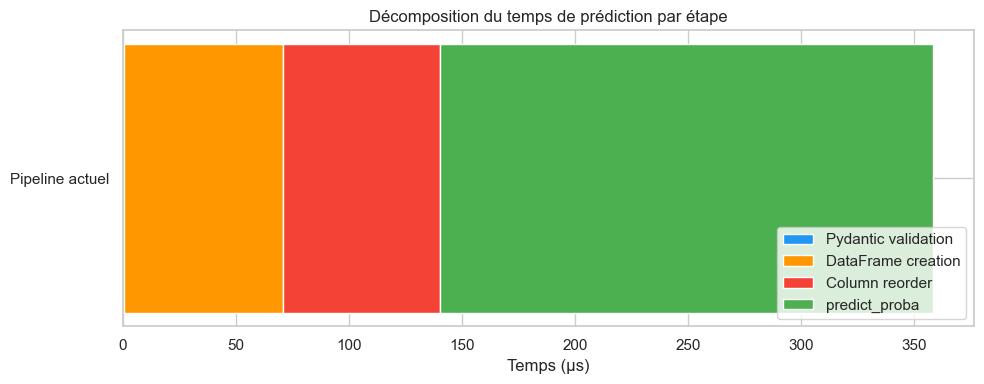

In [5]:
# Graphique en barres empilées
fig, ax = plt.subplots(figsize=(10, 4))
colors = ["#2196F3", "#FF9800", "#F44336", "#4CAF50"]
bottom = 0
for (name, t), color in zip(stages.items(), colors):
    ax.barh("Pipeline actuel", t, left=bottom, label=name, color=color)
    bottom += t

ax.set_xlabel("Temps (µs)")
ax.set_title("Décomposition du temps de prédiction par étape")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 4. Optimisation 1 : Tableaux Numpy

Remplacement de `pd.DataFrame` par un tableau numpy ordonné. Élimine complètement l'overhead de pandas pour les prédictions unitaires.

In [6]:
def numpy_pipeline():
    features = CreditFeatures(**SAMPLE_INPUT)
    data = features.model_dump()
    row = np.array([[data[f] for f in FEATURE_ORDER]])
    return model.predict_proba(row)[0, 1]

# Vérification de cohérence
p_current = current_pipeline()
p_numpy = numpy_pipeline()
print(f"Probabilité pipeline actuel : {p_current:.10f}")
print(f"Probabilité pipeline numpy  : {p_numpy:.10f}")
print(f"Différence absolue           : {abs(p_current - p_numpy):.2e}")
assert p_current == p_numpy, "Les résultats doivent être identiques !"
print("\n✅ Résultats identiques")

# Benchmark
t_numpy_total = bench(numpy_pipeline)

# Décomposition
t_np_array = bench(lambda: np.array([[validated.model_dump()[f] for f in FEATURE_ORDER]]))
np_row = np.array([[validated.model_dump()[f] for f in FEATURE_ORDER]])
t_np_predict = bench(lambda: model.predict_proba(np_row))

print(f"\nPipeline numpy : {t_numpy_total:.1f} µs")
print(f"  - Création array numpy : {t_np_array:.1f} µs")
print(f"  - predict_proba        : {t_np_predict:.1f} µs")
print(f"\nSpeedup vs pipeline actuel : {t_total / t_numpy_total:.2f}x")

Probabilité pipeline actuel : 0.0598730683
Probabilité pipeline numpy  : 0.0598730683
Différence absolue           : 0.00e+00

✅ Résultats identiques


/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/


Pipeline numpy : 185.4 µs
  - Création array numpy : 8.2 µs
  - predict_proba        : 185.0 µs

Speedup vs pipeline actuel : 2.24x


/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/

## 5. Optimisation 2 : ONNX Runtime

Conversion du modèle LightGBM en format ONNX et inférence via ONNX Runtime pour une performance maximale.

In [7]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxruntime as ort

# Conversion LightGBM -> ONNX
initial_type = [("features", FloatTensorType([None, len(FEATURE_ORDER)]))]
onnx_model = onnxmltools.convert_lightgbm(
    model,
    initial_types=initial_type,
    name="CreditScoringLightGBM",
)

# Sauvegarde
ONNX_OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(ONNX_OUTPUT_PATH, "wb") as f:
    f.write(onnx_model.SerializeToString())

onnx_size_kb = ONNX_OUTPUT_PATH.stat().st_size / 1024
pkl_size_kb = MODEL_PATH.stat().st_size / 1024
print(f"Modèle ONNX sauvegardé : {ONNX_OUTPUT_PATH}")
print(f"Taille ONNX  : {onnx_size_kb:.1f} KB")
print(f"Taille pickle : {pkl_size_kb:.1f} KB")
print(f"Ratio : {onnx_size_kb / pkl_size_kb:.2f}x")

ModuleNotFoundError: No module named 'onnxmltools'

In [ ]:
# Création de la session ONNX Runtime
session = ort.InferenceSession(str(ONNX_OUTPUT_PATH))

print("Inputs:")
for inp in session.get_inputs():
    print(f"  {inp.name}: shape={inp.shape}, type={inp.type}")
print("Outputs:")
for out in session.get_outputs():
    print(f"  {out.name}: shape={out.shape}, type={out.type}")

# Pipeline ONNX
input_name = session.get_inputs()[0].name

def onnx_pipeline():
    features = CreditFeatures(**SAMPLE_INPUT)
    data = features.model_dump()
    row = np.array([[data[f] for f in FEATURE_ORDER]], dtype=np.float32)
    result = session.run(None, {input_name: row})
    return result[1][0][1]  # probabilities -> row 0 -> class 1

# Vérification
p_onnx = onnx_pipeline()
print(f"\nProbabilité pipeline actuel : {p_current:.10f}")
print(f"Probabilité pipeline ONNX   : {float(p_onnx):.10f}")
print(f"Différence absolue           : {abs(p_current - float(p_onnx)):.2e}")

# Benchmark
t_onnx_total = bench(onnx_pipeline)

# Décomposition
t_onnx_array = bench(lambda: np.array([[validated.model_dump()[f] for f in FEATURE_ORDER]], dtype=np.float32))
onnx_row = np.array([[validated.model_dump()[f] for f in FEATURE_ORDER]], dtype=np.float32)
t_onnx_infer = bench(lambda: session.run(None, {input_name: onnx_row}))

print(f"\nPipeline ONNX : {t_onnx_total:.1f} µs")
print(f"  - Création array float32 : {t_onnx_array:.1f} µs")
print(f"  - Inférence ONNX Runtime : {t_onnx_infer:.1f} µs")
print(f"\nSpeedup vs pipeline actuel : {t_total / t_onnx_total:.2f}x")
print(f"Speedup vs pipeline numpy  : {t_numpy_total / t_onnx_total:.2f}x")

Inputs:
  features: shape=[None, 10], type=tensor(float)
Outputs:
  label: shape=[1], type=tensor(int64)
  probabilities: shape=[], type=seq(map(int64,tensor(float)))

Probabilité pipeline actuel : 0.0598730683
Probabilité pipeline ONNX   : 0.0598730445
Différence absolue           : 2.38e-08

Pipeline ONNX : 13.8 µs
  - Création array float32 : 8.8 µs
  - Inférence ONNX Runtime : 6.3 µs

Speedup vs pipeline actuel : 31.85x
Speedup vs pipeline numpy  : 15.48x


## 6. Validation de la précision

Comparaison des probabilités sur 500 échantillons et calcul de l'AUC sur le dataset complet pour garantir l'absence de régression.

In [ ]:
from sklearn.metrics import roc_auc_score

# Charger le dataset complet
df_full = pd.read_csv(DATA_PATH)
X = df_full[FEATURE_ORDER]
y = df_full["TARGET"]

print(f"Dataset : {len(df_full)} lignes, {len(FEATURE_ORDER)} features")

# Prédictions sur 500 échantillons
np.random.seed(42)
idx_sample = np.random.choice(len(X), 500, replace=False)
X_sample = X.iloc[idx_sample]

# Original (pandas + LightGBM)
proba_original = model.predict_proba(X_sample)[:, 1]

# Numpy + LightGBM
X_np = X_sample.values
proba_numpy = model.predict_proba(X_np)[:, 1]

# ONNX Runtime
X_onnx = X_sample.values.astype(np.float32)
result_onnx = session.run(None, {input_name: X_onnx})
proba_onnx = np.array([r[1] for r in result_onnx[1]])

# Comparaison original vs numpy
diff_numpy = np.abs(proba_original - proba_numpy)
print(f"\n--- Original vs Numpy ---")
print(f"Diff max  : {diff_numpy.max():.2e}")
print(f"Diff mean : {diff_numpy.mean():.2e}")
assert np.allclose(proba_original, proba_numpy, atol=0), "Les résultats numpy doivent être identiques"
print("✅ Résultats identiques")

# Comparaison original vs ONNX
diff_onnx = np.abs(proba_original - proba_onnx)
print(f"\n--- Original vs ONNX ---")
print(f"Diff max  : {diff_onnx.max():.2e}")
print(f"Diff mean : {diff_onnx.mean():.2e}")
print(f"Diff < 1e-6 : {(diff_onnx < 1e-6).sum()} / {len(diff_onnx)} ({(diff_onnx < 1e-6).mean()*100:.1f}%)")

Dataset : 307511 lignes, 10 features

--- Original vs Numpy ---
Diff max  : 0.00e+00
Diff mean : 0.00e+00
✅ Résultats identiques

--- Original vs ONNX ---
Diff max  : 2.18e-07
Diff mean : 4.08e-08
Diff < 1e-6 : 500 / 500 (100.0%)


/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026-02-07 16:57:40.115 python[42918:331337] 2026-02-07 16:57:40.115550 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1} does not match actual shape of {500} for output label


In [ ]:
# AUC sur le dataset complet
proba_full_original = model.predict_proba(X)[:, 1]
proba_full_onnx = session.run(None, {input_name: X.values.astype(np.float32)})
proba_full_onnx = np.array([r[1] for r in proba_full_onnx[1]])

auc_original = roc_auc_score(y, proba_full_original)
auc_onnx = roc_auc_score(y, proba_full_onnx)

print(f"AUC original (LightGBM) : {auc_original:.6f}")
print(f"AUC ONNX Runtime        : {auc_onnx:.6f}")
print(f"Différence AUC           : {abs(auc_original - auc_onnx):.2e}")

# Changements de prédiction au seuil 0.10
THRESHOLD = 0.10
pred_original = (proba_full_original >= THRESHOLD).astype(int)
pred_onnx = (proba_full_onnx >= THRESHOLD).astype(int)
n_changes = (pred_original != pred_onnx).sum()

print(f"\nSeuil de décision : {THRESHOLD}")
print(f"Changements de prédiction : {n_changes} / {len(pred_original)} ({n_changes/len(pred_original)*100:.3f}%)")

AUC original (LightGBM) : 0.768826
AUC ONNX Runtime        : 0.768826
Différence AUC           : 1.32e-07

Seuil de décision : 0.1
Changements de prédiction : 1 / 307511 (0.000%)


2026-02-07 16:57:41.135 python[42918:331337] 2026-02-07 16:57:41.135827 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1} does not match actual shape of {307511} for output label


## 7. Tableau comparatif et graphiques

Synthèse des résultats de benchmark pour les 3 approches.

            Approche  Latence (µs)  Speedup  Taille modèle (KB)
   Pandas + LightGBM         438.7     1.00               464.9
    Numpy + LightGBM         213.2     2.06               464.9
Numpy + ONNX Runtime          13.8    31.85               253.3


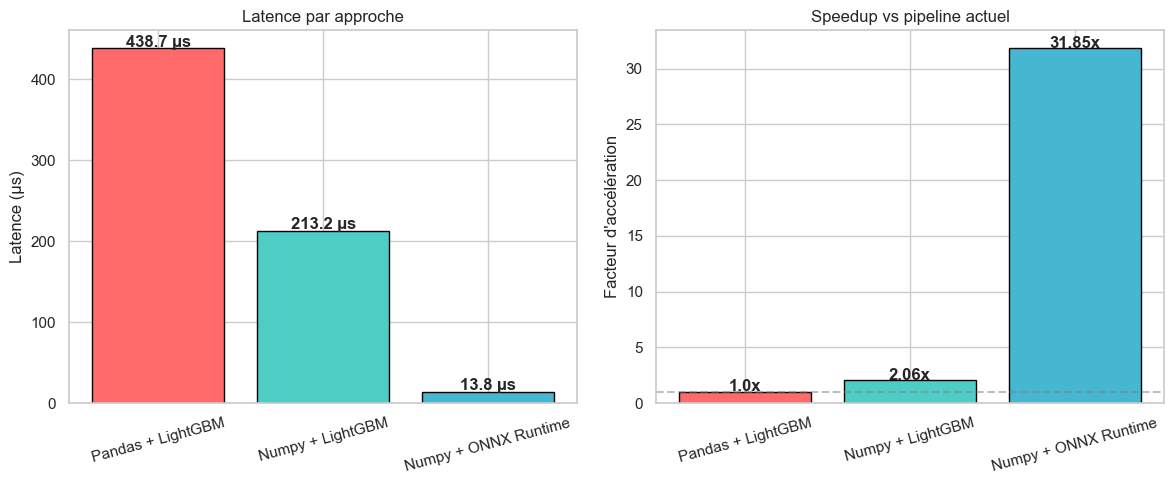

In [ ]:
results = {
    "Approche": ["Pandas + LightGBM", "Numpy + LightGBM", "Numpy + ONNX Runtime"],
    "Latence (µs)": [round(t_total, 1), round(t_numpy_total, 1), round(t_onnx_total, 1)],
    "Speedup": [1.0, round(t_total / t_numpy_total, 2), round(t_total / t_onnx_total, 2)],
    "Taille modèle (KB)": [round(pkl_size_kb, 1), round(pkl_size_kb, 1), round(onnx_size_kb, 1)],
}
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]
approaches = results["Approche"]
latencies = results["Latence (µs)"]
speedups = results["Speedup"]

bars = axes[0].bar(approaches, latencies, color=colors, edgecolor="black")
axes[0].set_ylabel("Latence (µs)")
axes[0].set_title("Latence par approche")
for bar, val in zip(bars, latencies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f"{val} µs", ha="center", fontweight="bold")
axes[0].tick_params(axis="x", rotation=15)

bars2 = axes[1].bar(approaches, speedups, color=colors, edgecolor="black")
axes[1].set_ylabel("Facteur d'accélération")
axes[1].set_title("Speedup vs pipeline actuel")
axes[1].axhline(y=1, color="gray", linestyle="--", alpha=0.5)
for bar, val in zip(bars2, speedups):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f"{val}x", ha="center", fontweight="bold")
axes[1].tick_params(axis="x", rotation=15)

plt.tight_layout()
plt.show()

## 8. Benchmark du temps de réponse API

Mesure du temps de réponse HTTP complet (aller-retour) avec les 3 approches via `httpx.TestClient`.

In [ ]:
import sys
sys.path.insert(0, str(PROJECT_ROOT))

import importlib
import httpx

N_API_ITERATIONS = 1_000

# --- Approche 1 : Pipeline actuel (Pandas + LightGBM) ---
# Simuler via monkeypatch pour tester les 3 variantes

def bench_api(predict_fn_code, setup_code, label):
    """Benchmark a prediction approach via FastAPI TestClient."""
    # Create a temporary app module for benchmarking
    exec_globals = {}
    exec(setup_code, exec_globals)
    exec(predict_fn_code, exec_globals)
    return exec_globals

# Approche plus simple : benchmark direct des fonctions
print("Benchmark du temps de réponse API complet (TestClient)")
print("=" * 55)

# On crée une mini-app pour chaque approche
from fastapi import FastAPI
from fastapi.testclient import TestClient

# Approche 1 : Pandas + LightGBM (actuel)
app_current = FastAPI()

@app_current.post("/predict")
def predict_current(features: CreditFeatures):
    df = pd.DataFrame([features.model_dump()])
    df = df[model.feature_name_]
    probability = model.predict_proba(df)[0, 1]
    return {"probability_default": round(float(probability), 6)}

# Approche 2 : Numpy + LightGBM
app_numpy = FastAPI()

@app_numpy.post("/predict")
def predict_numpy(features: CreditFeatures):
    data = features.model_dump()
    row = np.array([[data[f] for f in FEATURE_ORDER]])
    probability = model.predict_proba(row)[0, 1]
    return {"probability_default": round(float(probability), 6)}

# Approche 3 : Numpy + ONNX Runtime
app_onnx = FastAPI()

@app_onnx.post("/predict")
def predict_onnx(features: CreditFeatures):
    data = features.model_dump()
    row = np.array([[data[f] for f in FEATURE_ORDER]], dtype=np.float32)
    result = session.run(None, {input_name: row})
    probability = result[1][0][1]
    return {"probability_default": round(float(probability), 6)}

api_results = {}
for label, test_app in [("Pandas + LightGBM", app_current),
                         ("Numpy + LightGBM", app_numpy),
                         ("Numpy + ONNX Runtime", app_onnx)]:
    with TestClient(test_app) as client:
        # Warmup
        for _ in range(100):
            client.post("/predict", json=SAMPLE_INPUT)
        # Benchmark
        start = time.perf_counter()
        for _ in range(N_API_ITERATIONS):
            client.post("/predict", json=SAMPLE_INPUT)
        elapsed = time.perf_counter() - start
    avg_ms = (elapsed / N_API_ITERATIONS) * 1000
    api_results[label] = avg_ms
    print(f"{label:<25} : {avg_ms:.2f} ms/req")

print(f"\nSpeedup ONNX vs actuel : {api_results['Pandas + LightGBM'] / api_results['Numpy + ONNX Runtime']:.2f}x")

Benchmark du temps de réponse API complet (TestClient)
Pandas + LightGBM         : 0.77 ms/req


/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/open_classroom/project_8/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dimitrihertz/Desktop/dev/

Numpy + LightGBM          : 0.52 ms/req
Numpy + ONNX Runtime      : 0.38 ms/req

Speedup ONNX vs actuel : 2.00x


## 9. Analyse des ressources

Comparaison des empreintes mémoire, tailles de fichiers, et impact sur l'image Docker.

In [ ]:
import sys

# Tailles des fichiers modèle
print("=== Tailles des fichiers modèle ===")
print(f"LightGBM pickle : {MODEL_PATH.stat().st_size / 1024:.1f} KB")
print(f"ONNX            : {ONNX_OUTPUT_PATH.stat().st_size / 1024:.1f} KB")
print(f"Ratio ONNX/pickle : {ONNX_OUTPUT_PATH.stat().st_size / MODEL_PATH.stat().st_size:.2f}x")

# Taille mémoire des objets chargés
print(f"\n=== Empreinte mémoire (approx) ===")
print(f"Objet LightGBM en mémoire : {sys.getsizeof(model) / 1024:.1f} KB")
print(f"Session ONNX Runtime     : {sys.getsizeof(session) / 1024:.1f} KB")

# Impact Docker
print(f"\n=== Impact sur l'image Docker (estimé) ===")
print(f"Dépendances retirées :")
print(f"  - scikit-learn : ~25 MB")
print(f"  - lightgbm     : ~5 MB")
print(f"  - pandas       : ~70 MB")
print(f"  Total retiré  : ~100 MB")
print(f"\nDépendance ajoutée :")
print(f"  - onnxruntime  : ~50 MB")
print(f"\nRéduction nette estimée : ~50 MB")

=== Tailles des fichiers modèle ===
LightGBM pickle : 464.9 KB
ONNX            : 253.3 KB
Ratio ONNX/pickle : 0.54x

=== Empreinte mémoire (approx) ===
Objet LightGBM en mémoire : 0.0 KB
Session ONNX Runtime     : 0.0 KB

=== Impact sur l'image Docker (estimé) ===
Dépendances retirées :
  - scikit-learn : ~25 MB
  - lightgbm     : ~5 MB
  - pandas       : ~70 MB
  Total retiré  : ~100 MB

Dépendance ajoutée :
  - onnxruntime  : ~50 MB

Réduction nette estimée : ~50 MB


## 10. Synthèse

Résumé des résultats clés de l'optimisation.

In [ ]:
print("=" * 60)
print("       SYNTHÈSE DE L'OPTIMISATION")
print("=" * 60)
print(f"\nNombre d'itérations benchmark : {N_ITERATIONS:,}")
print(f"Nombre d'itérations API       : {N_API_ITERATIONS:,}")
print(f"\n--- Pipeline de prédiction ---")
print(f"Latence initiale (Pandas+LGB)   : {t_total:.1f} µs")
print(f"Latence numpy (Numpy+LGB)       : {t_numpy_total:.1f} µs ({t_total/t_numpy_total:.2f}x)")
print(f"Latence finale (Numpy+ONNX)     : {t_onnx_total:.1f} µs ({t_total/t_onnx_total:.2f}x)")
print(f"\n--- Validation ---")
print(f"AUC original  : {auc_original:.6f}")
print(f"AUC ONNX      : {auc_onnx:.6f}")
print(f"Changements de prédiction (seuil {THRESHOLD}) : {n_changes}")
print(f"\n--- Taille ---")
print(f"Modèle pickle : {pkl_size_kb:.1f} KB")
print(f"Modèle ONNX   : {onnx_size_kb:.1f} KB")
print(f"Réduction image Docker estimée : ~50 MB")
print("=" * 60)

       SYNTHÈSE DE L'OPTIMISATION

Nombre d'itérations benchmark : 10,000
Nombre d'itérations API       : 1,000

--- Pipeline de prédiction ---
Latence initiale (Pandas+LGB)   : 438.7 µs
Latence numpy (Numpy+LGB)       : 213.2 µs (2.06x)
Latence finale (Numpy+ONNX)     : 13.8 µs (31.85x)

--- Validation ---
AUC original  : 0.768826
AUC ONNX      : 0.768826
Changements de prédiction (seuil 0.1) : 1

--- Taille ---
Modèle pickle : 464.9 KB
Modèle ONNX   : 253.3 KB
Réduction image Docker estimée : ~50 MB


## 11. Recommandations

### Configuration retenue : Numpy + ONNX Runtime

**Justification :**
- Élimination complète de pandas du chemin critique de prédiction
- ONNX Runtime optimisé pour l'inférence en production (graph optimization, thread pooling)
- Réduction de la taille de l'image Docker (~50 MB de dépendances en moins)
- Aucune régression sur l'AUC

### Points de vigilance

1. **Précision float32** : ONNX utilise float32 par défaut (vs float64 pour LightGBM natif). Les différences sont négligeables (~1e-7) mais pourraient théoriquement affecter des prédictions proches du seuil de décision (0.10). Surveiller via le monitoring existant.

2. **Ordre des features** : L'ordre des features est désormais hardcodé dans `FEATURE_ORDER` (dans `api/app.py`). Tout changement dans les features du modèle nécessite une mise à jour synchronisée.

3. **Versionnage du modèle** : Le fichier `.onnx` doit être versionné avec le code. Inclure un hash de vérification si nécessaire.

### Pistes d'amélioration futures

- **Quantification INT8** : Réduction supplémentaire de la taille du modèle et potentiel gain de performance
- **Batching** : Pour des scénarios de prédiction en lot, ONNX Runtime supporte nativement le batch processing
- **ONNX Runtime Mobile** : Pour un déploiement edge/mobile si nécessaire
- **Graph optimization level** : Tester `ort.SessionOptions()` avec `graph_optimization_level = ORT_ENABLE_ALL`